In [47]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import re

In [48]:
file_path = './car_data2.json'  # Adjust the file path as needed
df = pd.read_json(file_path)

In [49]:
def extract_engine_l(engine_str):
    if isinstance(engine_str, str):  # Check if the input is a string
        match = re.search(r'(\d+\.\d+|\d+) *L', engine_str)
        return float(match.group(1)) if match else np.nan
    else:
        return np.nan  # Return NaN for non-string inputs
    
def convert_year_to_numeric(year_str):
    try:
        return int(year_str)
    except ValueError:
        return np.nan  # Return NaN if the conversion fails



def handle_mpg(mpg_str):
    if isinstance(mpg_str, str):  # Ensure the input is a string
        if '-' in mpg_str:
            parts = mpg_str.split('-')
            # Ensure both parts are numbers
            if all(part.isdigit() for part in parts):
                low, high = map(int, parts)
                return (low + high) / 2
        try:
            return float(mpg_str)
        except ValueError:
            return np.nan  # Return NaN if conversion fails
    elif isinstance(mpg_str, (int, float)):  # If it's already a number, just return it
        return mpg_str
    else:
        return np.nan  # Return NaN for any other unexpected data types

def safe_convert_to_int(mileage_str):
    # Remove ' mi.' and commas
    if isinstance(mileage_str, str):  # Ensure the input is a string
        clean_str = mileage_str.replace(' mi.', '').replace(',', '')
    # Try to convert to integer, handle cases where the conversion would fail
        try:
            return int(clean_str)
        except ValueError:
        # Return None or a specific value that indicates missing or malformed data
            return np.nan
    elif isinstance(mileage_str, (int, float)):  # If it's already a number, just return it
        return mileage_str

def safe_convert_price(price_str):
    # Remove '$' and commas
    if isinstance(price_str, str):  # Ensure the input is a string
        clean_str = price_str.replace('$', '').replace(',', '')
    # Try to convert to integer, handle cases where the conversion would fail
        try:
            return int(clean_str)
        except ValueError:
        # Return None or a specific value that indicates missing or malformed data
            return np.nan
    elif isinstance(price_str, (int, float)):  # If it's already a number, just return it
        return price_str
def handle_fuel_type(value):
    if pd.isna(value):
        return np.nan  # Handle null values explicitly if needed
    return 0 if value == 'Hybrid' else 1 if value == 'Gasoline' else np.nan

def handle_accidents(value):
    if pd.isna(value):
        return np.nan
    return 0 if value == 'None reported' else 1

def count_features(value):
    if pd.isna(value):
        return 0
    return len(value.split('\n'))

def handle_transmission(value):
    if pd.isna(value):
        return np.nan
    return 1 if 'manual' in value.lower() else 0

def handle_clean_title(value):
    if pd.isna(value):
        return np.nan
    return 1 if value.lower() == 'yes' else 0 if value.lower() == 'no' else np.nan

def handle_entertainment(value):
    if pd.isna(value):
        return 0
    # Splitting by various delimiters
    features = re.split(r'\u00ae/|\u00ae\n', value)
    # Counting non-empty entries after split to avoid counting empty strings as features
    return len([feature for feature in features if feature.strip()])

In [50]:
# Assuming df is your DataFrame loaded from the JSON file
df['Engine L'] = df['Engine'].apply(extract_engine_l)

# Verify outputs
print(df[['Engine', 'Engine L']].head())

                                              Engine  Engine L
0  2.5L I-4 DOHC, variable valve control, regular...       2.5
1                        2.5L I4 16V PDI DOHC Hybrid       2.5
2                             4.0L V6 DOHC VVT-i 24V       4.0
3                              4.0L V6 24V MPFI DOHC       4.0
4                              1.5L I4 16V MPFI DOHC       1.5


In [51]:

# Applying transformations
df['Model Year'] = df['Model Year'].apply(convert_year_to_numeric)

df['Fuel type'] = df['Fuel type'].apply(handle_fuel_type)
df['Personal use only'] = df['Personal use only'].map({'Yes': 1, 'No': 0})
df['1-owner vehicle'] = df['1-owner vehicle'].map({'Yes': 1, 'No': 0})
df['Accidents or damage'] = df['Accidents or damage'].apply(handle_accidents)
df['Safety features count'] = df['Safety'].apply(count_features)
df['Entertainment features count'] = df['Entertainment'].apply(handle_entertainment)
df['Transmission type'] = df['Transmission'].apply(handle_transmission)
df['Convenience count'] = df['Convenience'].apply(count_features)
df['Clean title'] = df['Clean title'].apply(handle_clean_title)  # Assuming there's a column 'Clean title'
df['MPG'] = df['MPG'].apply(handle_mpg)
df['Engine'] = df['Engine'].apply(extract_engine_l)
df['Mileage'] = df['Mileage'].apply(safe_convert_to_int)
median_mileage = df['Mileage'].median()
df['Mileage'].fillna(median_mileage, inplace=True)
df['Last Listed Price'] = df['Last Listed Price'].apply(safe_convert_price)
median_price = df['Last Listed Price'].median()
df['Last Listed Price'].fillna(median_price, inplace=True)

# Filling missing horsepower values with the median
df['Engine'].fillna(df['Engine'].median(), inplace=True)
# Example of filling missing values
df.fillna(df.median(numeric_only=True), inplace=True)

# df.fillna({
#     'Engine': df['Engine'].median(),
#     'MPG': df['MPG'].median(),
#     'Mileage': df['Mileage'].median()
# }, inplace=True)

/var/folders/pn/y9k087rn6zl5k_n7y1_2438r0000gn/T/ipykernel_3402/971199538.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Mileage'].fillna(median_mileage, inplace=True)
/var/folders/pn/y9k087rn6zl5k_n7y1_2438r0000gn/T/ipykernel_3402/971199538.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alwa

In [52]:
print(df[['Entertainment', 'Entertainment features count']].head())

                                       Entertainment  \
0                                                NaN   
1  Apple CarPlay®/Android Auto®\nBluetooth®\nHome...   
2                                                NaN   
3                                         Bluetooth®   
4                                         Bluetooth®   

   Entertainment features count  
0                             0  
1                             4  
2                             0  
3                             1  
4                             1  


In [53]:
# categorical_columns = ['Exterior color', 'Interior color', 'Drivetrain', 'Fuel type', 'Transmission',"VIN","Stock #","Convenience","Entertainment"]
# df_encoded = pd.get_dummies(df, columns=categorical_columns)

keep_columns = [
    'Engine','Model Year', 'MPG', 'Mileage', 
    'Fuel type', 'Personal use only', '1-owner vehicle',
    'Accidents or damage', 'Safety features count',
    'Entertainment features count', 'Transmission type',
    'Convenience count','Last Listed Price'
]

# Filter the DataFrame to only include these columns
df_encoded = df[keep_columns]




# print(df.head)
display(df_encoded)

,Engine,Model Year,MPG,Mileage,Fuel type,Personal use only,1-owner vehicle,Accidents or damage,Safety features count,Entertainment features count,Transmission type,Convenience count,Last Listed Price
0,2.5,2011,27.0,169197.0,1.0,1.0,1.0,1.0,3,0,0,0,7594.0
1,2.5,2023,36.0,45807.0,0.0,0.0,1.0,0.0,5,4,0,3,40899.0
2,4.0,2007,17.5,217723.0,1.0,1.0,0.0,1.0,3,0,1,0,9999.0
3,4.0,2012,18.5,63719.0,1.0,1.0,1.0,0.0,2,1,0,0,28988.0
4,1.5,2012,32.5,120733.0,1.0,1.0,0.0,1.0,2,1,0,0,9227.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,3.5,2018,23.0,63537.5,1.0,0.0,0.0,0.0,5,2,0,1,25241.5
97,2.2,1999,26.5,190664.0,1.0,1.0,0.0,0.0,0,0,0,0,5477.0
98,1.8,2011,49.5,202938.0,1.0,1.0,0.0,0.0,3,1,0,2,8995.0
99,5.7,2016,15.5,87598.0,1.0,0.0,1.0,0.0,8,2,0,5,56995.0


In [54]:
X = df_encoded.drop('Last Listed Price', axis=1)
y = df_encoded['Last Listed Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [55]:
### 3. Build and Train the Model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [56]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f'Model Root Mean Squared Error: {rmse}')

Model Root Mean Squared Error: 6633.569471669044


In [57]:
average_price = df['Last Listed Price'].mean()
rmse_percent = (rmse / average_price) * 100
print(rmse_percent)

24.877130914731072


In [58]:
mean_price = np.mean(y_test)
baseline_predictions = [mean_price] * len(y_test)
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_predictions))
print(f"Baseline RMSE: {baseline_rmse}")

Baseline RMSE: 11839.63162582128


In [59]:
correlation_matrix = df_encoded.corr()
display(correlation_matrix)

,Engine,Model Year,MPG,Mileage,Fuel type,Personal use only,1-owner vehicle,Accidents or damage,Safety features count,Entertainment features count,Transmission type,Convenience count,Last Listed Price
Engine,1.000000,-0.096499,-0.641256,0.191877,0.212881,0.023040,0.026089,-0.202018,-0.024595,-0.105081,-0.162311,0.058939,0.395108
Model Year,-0.096499,1.000000,0.254520,-0.795654,-0.297029,-0.187154,0.434688,-0.149895,0.730476,0.798396,-0.262287,0.610176,0.511239
MPG,-0.641256,0.254520,1.000000,-0.266370,-0.523070,-0.111299,0.000690,0.028386,0.064037,0.289105,-0.019466,0.131713,-0.149289
Mileage,0.191877,-0.795654,-0.266370,1.000000,0.300681,0.179434,-0.407101,0.228979,-0.608644,-0.654234,0.066377,-0.471957,-0.492995
Fuel type,0.212881,-0.297029,-0.523070,0.300681,1.000000,0.038095,-0.075753,-0.105711,-0.231529,-0.346766,0.139814,-0.436369,-0.157941
Personal use only,0.023040,-0.187154,-0.111299,0.179434,0.038095,1.000000,-0.125435,0.196462,-0.200099,-0.108628,0.043751,-0.098978,-0.107345
1-owner vehicle,0.026089,0.434688,0.000690,-0.407101,-0.075753,-0.125435,1.000000,-0.273614,0.246112,0.393036,-0.012576,0.196819,0.331805
Accidents or damage,-0.202018,-0.149895,0.028386,0.228979,-0.105711,0.196462,-0.273614,1.000000,-0.107926,-0.116252,-0.050992,-0.070788,-0.236746
Safety features count,-0.024595,0.730476,0.064037,-0.608644,-0.231529,-0.200099,0.246112,-0.107926,1.000000,0.705036,-0.194756,0.708259,0.409212
Entertainment features count,-0.105081,0.798396,0.289105,-0.654234,-0.346766,-0.108628,0.393036,-0.116252,0.705036,1.000000,-0.241118,0.588060,0.313393


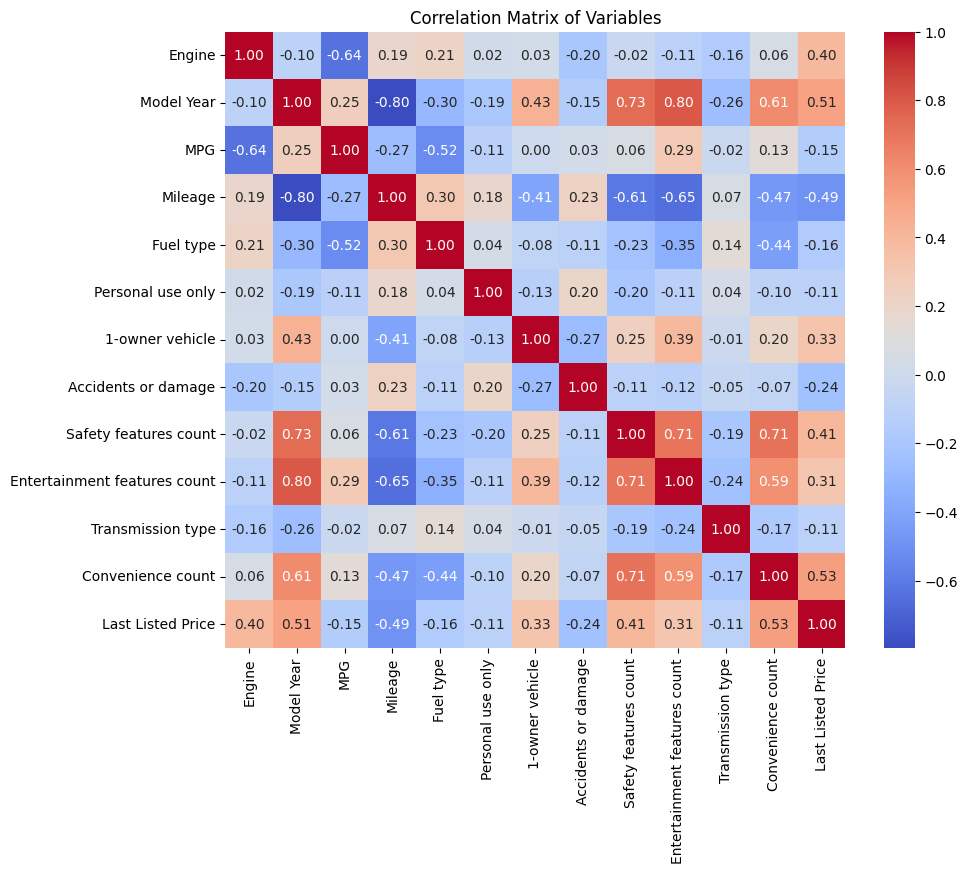

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Variables')
plt.show()


In [61]:
# Assuming df is your DataFrame and 'Last Listed Price' is your target for regression

df=df_encoded
median_price = df['Last Listed Price'].median()
# Create a binary target variable
df['Price Category'] = (df['Last Listed Price'] > median_price).astype(int)  # 1 if above median, 0 if below


In [62]:
# Use all or selected features from your regression model
features = df.drop(['Last Listed Price', 'Price Category'], axis=1)
target = df['Price Category']
display(df)


,Engine,Model Year,MPG,Mileage,Fuel type,Personal use only,1-owner vehicle,Accidents or damage,Safety features count,Entertainment features count,Transmission type,Convenience count,Last Listed Price,Price Category
0,2.5,2011,27.0,169197.0,1.0,1.0,1.0,1.0,3,0,0,0,7594.0,0
1,2.5,2023,36.0,45807.0,0.0,0.0,1.0,0.0,5,4,0,3,40899.0,1
2,4.0,2007,17.5,217723.0,1.0,1.0,0.0,1.0,3,0,1,0,9999.0,0
3,4.0,2012,18.5,63719.0,1.0,1.0,1.0,0.0,2,1,0,0,28988.0,1
4,1.5,2012,32.5,120733.0,1.0,1.0,0.0,1.0,2,1,0,0,9227.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,3.5,2018,23.0,63537.5,1.0,0.0,0.0,0.0,5,2,0,1,25241.5,0
97,2.2,1999,26.5,190664.0,1.0,1.0,0.0,0.0,0,0,0,0,5477.0,0
98,1.8,2011,49.5,202938.0,1.0,1.0,0.0,0.0,3,1,0,2,8995.0,0
99,5.7,2016,15.5,87598.0,1.0,0.0,1.0,0.0,8,2,0,5,56995.0,1


In [63]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)


In [64]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(random_state=42)
classifier.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [65]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix

# Assuming 'predictions' are already computed as shown in your snippet
predictions = classifier.predict(X_test)

# Calculate accuracy and ROC AUC score
rf_accuracy=accuracy_score(y_test, predictions)
print("Accuracy:", rf_accuracy)
rf_auc=roc_auc_score(y_test, classifier.predict_proba(X_test)[:, 1])
print("ROC AUC Score:",rf_auc)
# Classification report
print("Classification Report:\n", classification_report(y_test, predictions))

# Confusion matrix
cm = confusion_matrix(y_test, predictions)
tn, fp, fn, tp = cm.ravel()
print("Confusion Matrix:")
print(cm)
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")


Accuracy: 0.6190476190476191
ROC AUC Score: 0.763888888888889
Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.92      0.73        12
           1       0.67      0.22      0.33         9

    accuracy                           0.62        21
   macro avg       0.64      0.57      0.53        21
weighted avg       0.63      0.62      0.56        21

Confusion Matrix:
[[11  1]
 [ 7  2]]
True Negatives: 11
False Positives: 1
False Negatives: 7
True Positives: 2


In [66]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize the Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Fit the classifier to the training data
dt_classifier.fit(X_train, y_train)

# Make predictions
dt_predictions = dt_classifier.predict(X_test)

# Evaluate the classifier
dt_accuracy = accuracy_score(y_test, dt_predictions)
dt_report = classification_report(y_test, dt_predictions)
dt_cm = confusion_matrix(y_test, dt_predictions)
dt_auc = roc_auc_score(y_test, dt_classifier.predict_proba(X_test)[:, 1])

print("ROC AUC Score:",dt_auc)
print(f"Accuracy of Decision Tree: {dt_accuracy}")
print("Classification Report for Decision Tree:\n", dt_report)
print("Confusion Matrix for Decision Tree:\n", dt_cm)



ROC AUC Score: 0.4583333333333333
Accuracy of Decision Tree: 0.5238095238095238
Classification Report for Decision Tree:
               precision    recall  f1-score   support

           0       0.55      0.92      0.69        12
           1       0.00      0.00      0.00         9

    accuracy                           0.52        21
   macro avg       0.28      0.46      0.34        21
weighted avg       0.31      0.52      0.39        21

Confusion Matrix for Decision Tree:
 [[11  1]
 [ 9  0]]


In [67]:
print(f"Decision Tree Accuracy: {dt_accuracy}, ROC AUC: {dt_auc}")
print(f"Random Forest Accuracy: {rf_accuracy}, ROC AUC: {rf_auc}")
df=df.drop('Price Category',axis=1)

Decision Tree Accuracy: 0.5238095238095238, ROC AUC: 0.4583333333333333
Random Forest Accuracy: 0.6190476190476191, ROC AUC: 0.763888888888889


In [68]:
correlations = df.corr()['Last Listed Price'].drop('Last Listed Price')  # Exclude self-correlation
display(df)
# Filter features based on the correlation threshold
selected_features = correlations[abs(correlations) > 0.2].index.tolist()
print(f"Selected features based on correlation > 0.2: {selected_features}")


,Engine,Model Year,MPG,Mileage,Fuel type,Personal use only,1-owner vehicle,Accidents or damage,Safety features count,Entertainment features count,Transmission type,Convenience count,Last Listed Price
0,2.5,2011,27.0,169197.0,1.0,1.0,1.0,1.0,3,0,0,0,7594.0
1,2.5,2023,36.0,45807.0,0.0,0.0,1.0,0.0,5,4,0,3,40899.0
2,4.0,2007,17.5,217723.0,1.0,1.0,0.0,1.0,3,0,1,0,9999.0
3,4.0,2012,18.5,63719.0,1.0,1.0,1.0,0.0,2,1,0,0,28988.0
4,1.5,2012,32.5,120733.0,1.0,1.0,0.0,1.0,2,1,0,0,9227.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,3.5,2018,23.0,63537.5,1.0,0.0,0.0,0.0,5,2,0,1,25241.5
97,2.2,1999,26.5,190664.0,1.0,1.0,0.0,0.0,0,0,0,0,5477.0
98,1.8,2011,49.5,202938.0,1.0,1.0,0.0,0.0,3,1,0,2,8995.0
99,5.7,2016,15.5,87598.0,1.0,0.0,1.0,0.0,8,2,0,5,56995.0


Selected features based on correlation > 0.2: ['Engine', 'Model Year', 'Mileage', '1-owner vehicle', 'Accidents or damage', 'Safety features count', 'Entertainment features count', 'Convenience count']


In [69]:
df_reduced = df[selected_features + ['Last Listed Price']]
display(df_reduced)

,Engine,Model Year,Mileage,1-owner vehicle,Accidents or damage,Safety features count,Entertainment features count,Convenience count,Last Listed Price
0,2.5,2011,169197.0,1.0,1.0,3,0,0,7594.0
1,2.5,2023,45807.0,1.0,0.0,5,4,3,40899.0
2,4.0,2007,217723.0,0.0,1.0,3,0,0,9999.0
3,4.0,2012,63719.0,1.0,0.0,2,1,0,28988.0
4,1.5,2012,120733.0,0.0,1.0,2,1,0,9227.0
...,...,...,...,...,...,...,...,...,...
96,3.5,2018,63537.5,0.0,0.0,5,2,1,25241.5
97,2.2,1999,190664.0,0.0,0.0,0,0,0,5477.0
98,1.8,2011,202938.0,0.0,0.0,3,1,2,8995.0
99,5.7,2016,87598.0,1.0,0.0,8,2,5,56995.0


In [70]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Using the full feature set
X_full = df.drop('Last Listed Price', axis=1)
y_full = df['Last Listed Price']
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_full, y_full, test_size=0.2, random_state=42)

# Using the reduced feature set
X_reduced = df_reduced.drop('Last Listed Price', axis=1)
y_reduced = df_reduced['Last Listed Price']
X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = train_test_split(X_reduced, y_reduced, test_size=0.2, random_state=42)

# Fit and evaluate the full model
model_full = RandomForestRegressor(random_state=42)
model_full.fit(X_train_full, y_train_full)
mse_full = mean_squared_error(y_test_full, model_full.predict(X_test_full))

# Fit and evaluate the reduced model
model_reduced = RandomForestRegressor(random_state=42)
model_reduced.fit(X_train_reduced, y_train_reduced)
mse_reduced = mean_squared_error(y_test_reduced, model_reduced.predict(X_test_reduced))

print(f"Full model MSE: {mse_full}")
print(f"Reduced model MSE: {mse_reduced}")

Full model MSE: 44004243.935459524
Reduced model MSE: 39986620.32936666


In [71]:
correlation_matrix = df_reduced.corr()
display(correlation_matrix)

,Engine,Model Year,Mileage,1-owner vehicle,Accidents or damage,Safety features count,Entertainment features count,Convenience count,Last Listed Price
Engine,1.000000,-0.096499,0.191877,0.026089,-0.202018,-0.024595,-0.105081,0.058939,0.395108
Model Year,-0.096499,1.000000,-0.795654,0.434688,-0.149895,0.730476,0.798396,0.610176,0.511239
Mileage,0.191877,-0.795654,1.000000,-0.407101,0.228979,-0.608644,-0.654234,-0.471957,-0.492995
1-owner vehicle,0.026089,0.434688,-0.407101,1.000000,-0.273614,0.246112,0.393036,0.196819,0.331805
Accidents or damage,-0.202018,-0.149895,0.228979,-0.273614,1.000000,-0.107926,-0.116252,-0.070788,-0.236746
Safety features count,-0.024595,0.730476,-0.608644,0.246112,-0.107926,1.000000,0.705036,0.708259,0.409212
Entertainment features count,-0.105081,0.798396,-0.654234,0.393036,-0.116252,0.705036,1.000000,0.588060,0.313393
Convenience count,0.058939,0.610176,-0.471957,0.196819,-0.070788,0.708259,0.588060,1.000000,0.527464
Last Listed Price,0.395108,0.511239,-0.492995,0.331805,-0.236746,0.409212,0.313393,0.527464,1.000000


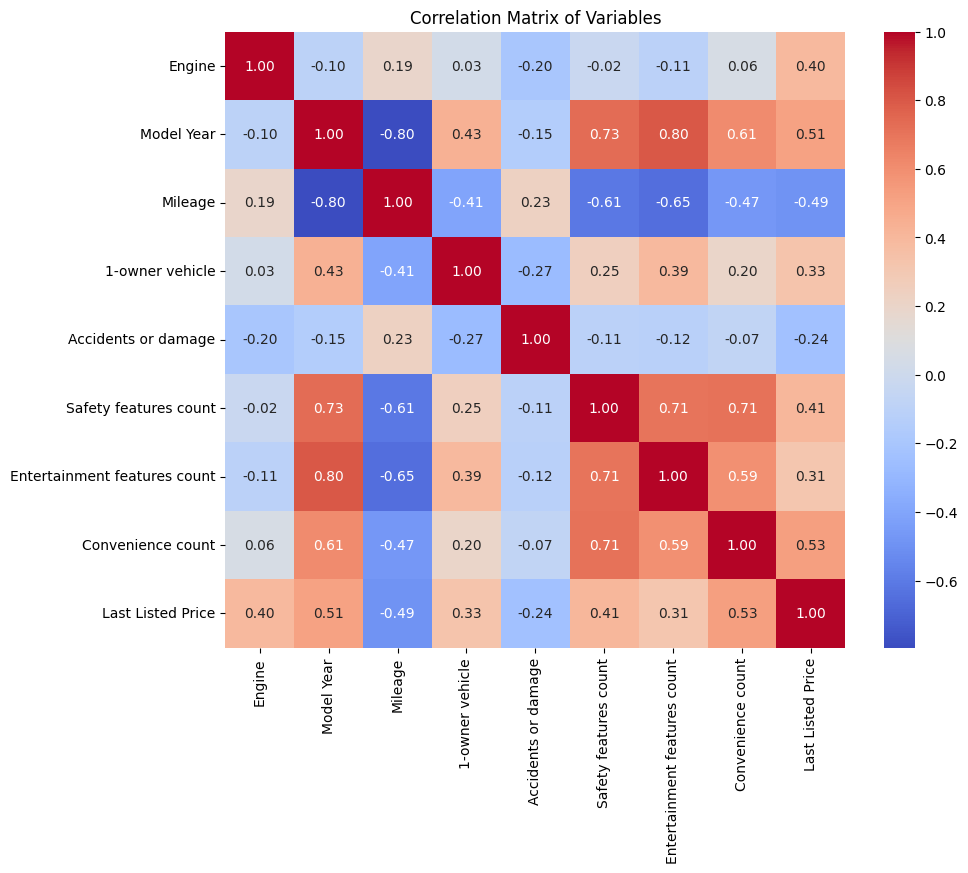

In [72]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Variables')
plt.show()

In [73]:
##droping high inter-corelated to reduce thge noise
df_reduced=df_reduced.drop(['Mileage','Entertainment features count','Safety features count'],axis=1)

In [74]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Using the full feature set
X_full = df.drop('Last Listed Price', axis=1)
y_full = df['Last Listed Price']
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_full, y_full, test_size=0.2, random_state=42)

# Using the reduced feature set
X_reduced = df_reduced.drop('Last Listed Price', axis=1)
y_reduced = df_reduced['Last Listed Price']
X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = train_test_split(X_reduced, y_reduced, test_size=0.2, random_state=42)

# Fit and evaluate the full model
model_full = RandomForestRegressor(random_state=42)
model_full.fit(X_train_full, y_train_full)
mse_full = mean_squared_error(y_test_full, model_full.predict(X_test_full))

# Fit and evaluate the reduced model
model_reduced = RandomForestRegressor(random_state=42)
model_reduced.fit(X_train_reduced, y_train_reduced)
mse_reduced = mean_squared_error(y_test_reduced, model_reduced.predict(X_test_reduced))

print(f"Full model MSE: {mse_full}")
print(f"Reduced model MSE: {mse_reduced}")

Full model MSE: 44004243.935459524
Reduced model MSE: 38572700.83268434


In [75]:
correlation_matrix = df_reduced.corr()
display(correlation_matrix)

,Engine,Model Year,1-owner vehicle,Accidents or damage,Convenience count,Last Listed Price
Engine,1.000000,-0.096499,0.026089,-0.202018,0.058939,0.395108
Model Year,-0.096499,1.000000,0.434688,-0.149895,0.610176,0.511239
1-owner vehicle,0.026089,0.434688,1.000000,-0.273614,0.196819,0.331805
Accidents or damage,-0.202018,-0.149895,-0.273614,1.000000,-0.070788,-0.236746
Convenience count,0.058939,0.610176,0.196819,-0.070788,1.000000,0.527464
Last Listed Price,0.395108,0.511239,0.331805,-0.236746,0.527464,1.000000


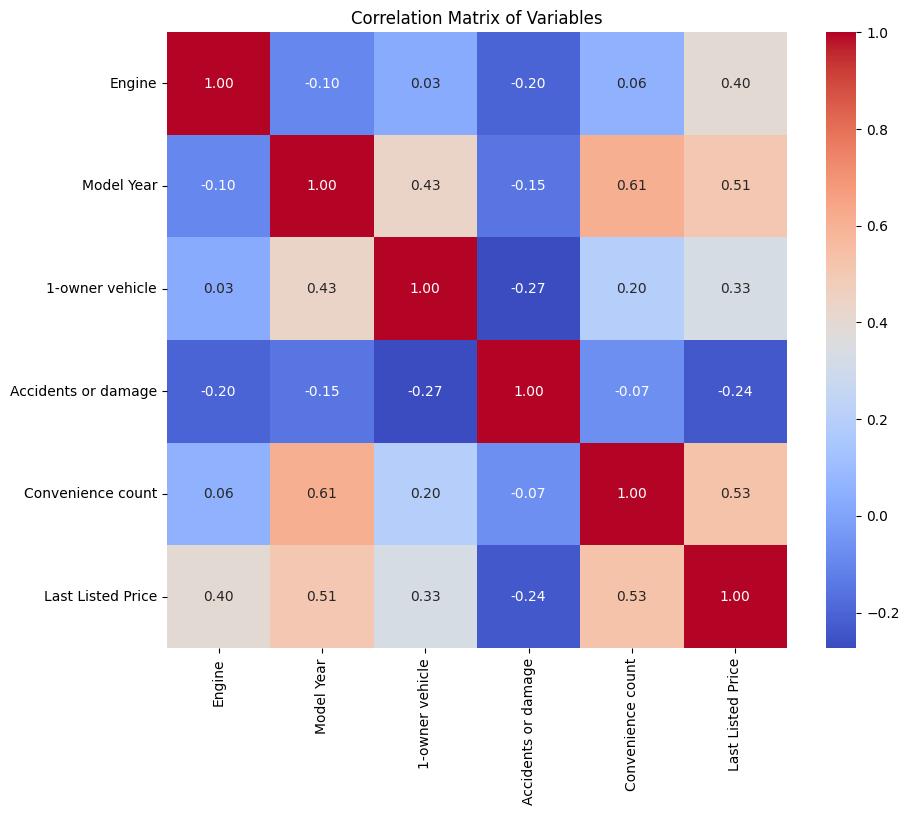

In [76]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Variables')
plt.show()

In [77]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Define the model
model = RandomForestRegressor(random_state=42)

# Define the parameters grid to search
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees
    'max_depth': [None, 10, 20, 30],  # Maximum depth of each tree
    'min_samples_split': [2, 5, 10]  # Minimum number of samples required to split a node
}

# Setup the grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

# Fit grid search to the data
grid_search.fit(X_train_reduced, y_train_reduced)

# Best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best RMSE:", np.sqrt(-grid_search.best_score_))




Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, min_samples_split=2, n_estimators=300; total time=   0.2s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, min_samples_split=2, n_estimators=300; total time=   0.2s
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, 

In [78]:
max_price = y_train_reduced.max()
min_price = y_train_reduced.min()
print(f"Maximum Last Listed Price: {max_price}")
print(f"Minimum Last Listed Price: {min_price}")

Maximum Last Listed Price: 65887.0
Minimum Last Listed Price: 5995.0


In [79]:
print(f"Range of Last Listed Price: {max_price - min_price}")
diff=max_price - min_price
rmse_from_grid_search=np.sqrt(-grid_search.best_score_)
print(f"RMSE: {rmse_from_grid_search}")  # Assuming `rmse_from_grid_search` holds the RMSE value you mentioned earlier


Range of Last Listed Price: 59892.0
RMSE: 8912.99986144453


In [80]:
error_prop=rmse_from_grid_search/diff*100
print(error_prop)

14.881786985648384


In [81]:
# Use the best parameters from the grid search
best_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    min_samples_split=5,
    random_state=42
)

# Train the model using the training set
best_model.fit(X_train_reduced, y_train_reduced)

# Predict on the testing set
y_pred = best_model.predict(X_test_reduced)

# Calculate the RMSE for the testing set
test_rmse = np.sqrt(mean_squared_error(y_test_reduced, y_pred))
print(f"Test RMSE: {test_rmse}")
error_prop=test_rmse/diff*100
print(error_prop)


Test RMSE: 6365.094073862361
10.6276198388138


In [82]:
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]
print("Feature ranking:")

for f in range(X_train_reduced.shape[1]):
    print(f"{f + 1}. feature {X_train_reduced.columns[indices[f]]} ({importances[indices[f]]})")


Feature ranking:
1. feature Engine (0.35470066813666606)
2. feature Model Year (0.30876552353614756)
3. feature Convenience count (0.27899554402955135)
4. feature Accidents or damage (0.03025265393373902)
5. feature 1-owner vehicle (0.027285610363896037)


In [91]:
# Use the best parameters from the grid search
best_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    min_samples_split=5,
    random_state=42
)
X_train_reduced_updated = X_train_reduced.drop(['Accidents or damage'], axis=1)
X_test_reduced_updated=X_test_reduced.drop(['Accidents or damage'], axis=1)
# Train the model using the training set
best_model.fit(X_train_reduced_updated, y_train_reduced)

# Predict on the testing set
y_pred = best_model.predict(X_test_reduced_updated)

# Calculate the RMSE for the testing set
test_rmse = np.sqrt(mean_squared_error(y_test_reduced, y_pred))
print(f"Test RMSE: {test_rmse}")
error_prop=test_rmse/diff*100
print(error_prop)

Test RMSE: 6171.520626445019
10.304415658927768


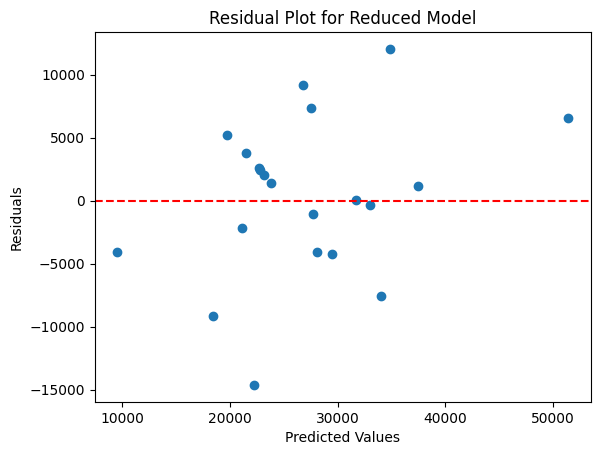

In [98]:
# Assuming `model_reduced` has been fit as shown in your script
# Predict on the test set
y_pred_reduced = best_model.predict(X_test_reduced_updated)

# Calculate residuals
residuals_reduced = y_test_reduced - y_pred_reduced

# Plotting residuals
plt.scatter(y_pred_reduced, residuals_reduced)
plt.title('Residual Plot for Reduced Model')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()


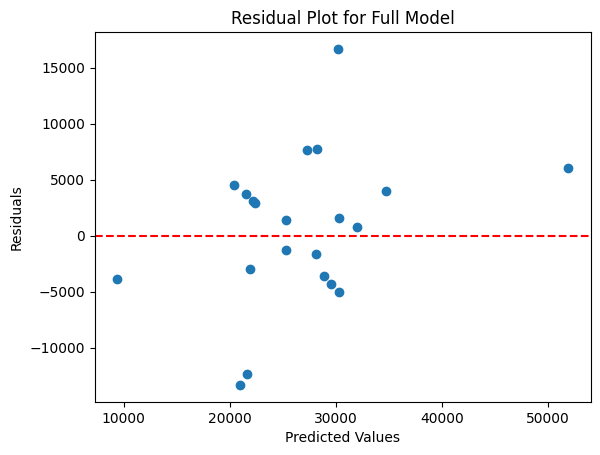

In [99]:
# Predict on the test set for the full model
y_pred_full = model_full.predict(X_test_full)

# Calculate residuals for the full model
residuals_full = y_test_full - y_pred_full

# Plotting residuals for the full model
plt.scatter(y_pred_full, residuals_full)
plt.title('Residual Plot for Full Model')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()